In [1]:
import scqubits as scqubits
import numpy as np
import scipy as sci
from system import *

In [2]:
class Hamiltonian:
    def __init__(self, phi_ex, Ej, Ec):
        self.phi_ex = phi_ex
        self.Ej = Ej * 2*np.pi
        self.Ec = Ec * 2*np.pi
        self.beta = 1
        self.N = 1
        self.sdim = 10
        self.cdim = 6
        self.epsilon =1e-4
        self.get_H()
        self.get_H_der()

    def annihilation(self, dim):
        return np.diag(np.sqrt(np.arange(1,dim)),1)
    def creation(self, dim):
        return np.diag(np.sqrt(np.arange(1,dim)),-1)
    

    def sort_eigenpairs(self, eigenvalues, eigenvectors):
        n = eigenvectors.shape[0]
        sorted_indices = []

        for i in range(n):
            max_abs_vals = np.abs(eigenvectors[i, :])
            max_index = np.argmax(max_abs_vals)
            while max_index in sorted_indices:
                max_abs_vals[max_index] = -np.inf
                max_index = np.argmax(max_abs_vals)
            sorted_indices.append(max_index)

        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]
        return sorted_eigenvalues, sorted_eigenvectors

    def get_H(self):
        #if we want to use scqubits, replace Hs,charge_op with the ones obtained from scqubits
        Hs,charge_op, phi_zpf = SNAIL(self.phi_ex, self.beta, self.N, self.Ej, self.Ec)
        squid = [Hs,charge_op]
        cavity = scqubits.Oscillator(
            E_osc=5.226,
            truncated_dim = 6
        )
        Hc = np.diag(cavity.eigenvals() - cavity.eigenvals()[0])*2*np.pi
        Vc = cavity.creation_operator() + cavity.annihilation_operator()
        cavity = [Hc,Vc]
        H,H_control = composite_sys(squid,cavity)
        evals,evecs = np.linalg.eigh(H)
        evals,evecs = self.sort_eigenpairs(evals,evecs)
        evals = evals - evals[0]
        self.omega_c = evals[1]
        self.omega_s = evals[self.cdim]
        self.chi = evals[self.cdim+1] - evals[self.cdim] - evals[1]
        self.anh = evals[2*self.cdim] - 2*evals[self.cdim]
        self.phi_zpf = phi_zpf
        self.H, self.H_control = H,H_control
        
        
    def get_H_der(self):
        original_phi = self.phi_ex
        Hs,charge_op, phi_zpf = SNAIL(self.phi_ex+self.epsilon, self.beta, self.N, self.Ej, self.Ec)
        squid = [Hs,charge_op]
        cavity = scqubits.Oscillator(
            E_osc=5.226,
            truncated_dim = 6
        )
        Hc = np.diag(cavity.eigenvals() - cavity.eigenvals()[0])*2*np.pi
        Vc = cavity.creation_operator() + cavity.annihilation_operator()
        cavity = [Hc,Vc]
        H,H_control = composite_sys(squid,cavity)
        self.H_per = H
        self.H_control_per = H_control
        evals,evecs = np.linalg.eigh(H)
        evals,evecs = self.sort_eigenpairs(evals,evecs)
        evals = evals - evals[0]
        self.omega_s_per = evals[self.cdim]
        self.omega_c_per = evals[1]
        

    
    def static_rate(self, der):
        A = 5e-6
        return np.abs(der*4.4)*1e6*A
    
    def exact_energy(self, A, omega):
        return calculate_floquet_energies(A, omega, self.H, self.H_control)[0]
    
    def calculate_dr_exact(self, A, omega):
        energy01,energy02,energy03= calculate_floquet_energies(A, omega, self.H, self.H_control)
        energy01_,energy02_,energy03_ = calculate_floquet_energies(A, omega, self.H_per, self.H_control_per)
        der1 = (energy01_ - energy01) / self.epsilon
        der2 = (energy02_ - energy01_ - (energy02 - energy01)) / self.epsilon
        der3 = (energy03_ - energy02_ - (energy03 - energy02)) / self.epsilon
        return self.static_rate(der1), self.static_rate(der2), self.static_rate(der3)
    
    
    def H_approximation(self, A, omega,):
        self.get_H()
        s = self.annihilation(self.sdim)
        sd = self.creation(self.sdim)
        c = self.annihilation(self.cdim)
        cd = self.creation(self.cdim)
        Is = np.eye(self.sdim)
        Ic = np.eye(self.cdim)
        H = ((self.omega_s - omega)* np.kron(sd@s,Ic) + self.anh/2 *np.kron(sd@sd@s@s,Ic) + self.omega_c*np.kron(Is,cd@c) 
        +self.chi*np.kron(sd@s,cd@c) + A/2/2/self.phi_zpf*(np.kron(s+sd,Ic)))

        evals,evecs = np.linalg.eigh(H)
        evals,evecs = self.sort_eigenpairs(evals,evecs)
        evals = evals - evals[0]
        return evals[1]
    
    def H_approximation_per(self, A, omega, consider_g, anh = None):
        Hs,charge_op, _ = SNAIL(self.phi_ex, self.beta, self.N, self.Ej, self.Ec)
        anh_ = Hs[2,2] - 2*Hs[1,1]
        if consider_g == True:
            Hs,charge_op,_ = SNAIL(self.phi_ex+self.epsilon, self.beta, self.N, self.Ej, self.Ec)
            omega_s_per = Hs[1,1] 
        else:
            Hs,_,_ = SNAIL(self.phi_ex+self.epsilon, self.beta, self.N, self.Ej, self.Ec)
            omega_s_per = Hs[1,1] 

        s = self.annihilation(self.sdim)
        sd = self.creation(self.sdim)
        Hs = omega_s_per*sd@s + anh_/2 *sd@sd@s@s
        Hs = Hs[:self.sdim,:self.sdim]
        charge_op = charge_op[:self.sdim,:self.sdim]
        squid = [Hs,charge_op]
        cavity = scqubits.Oscillator(
            E_osc=5.226,
            truncated_dim = 6
        )
        Hc = np.diag(cavity.eigenvals() - cavity.eigenvals()[0])*2*np.pi
        Vc = cavity.creation_operator() + cavity.annihilation_operator()
        cavity = [Hc,Vc]
        H,_ = composite_sys(squid,cavity)
        evals,evecs = np.linalg.eigh(H)
        evals,evecs = self.sort_eigenpairs(evals,evecs)
        evals = evals - evals[0]
        omega_s = evals[self.cdim]
        omega_c = evals[1]
        chi = evals[self.cdim+1] - evals[self.cdim] - evals[1]

        s = self.annihilation(self.sdim)
        sd = self.creation(self.sdim)
        c = self.annihilation(self.cdim)
        cd = self.creation(self.cdim)
        Is = np.eye(self.sdim)
        Ic = np.eye(self.cdim)
        if anh is None:
            anh = anh_
        H = ((omega_s - omega)* np.kron(sd@s,Ic) + anh/2 *np.kron(sd@sd@s@s,Ic) + omega_c*np.kron(Is,cd@c) 
        +chi*np.kron(sd@s,cd@c) + A/2/2/self.phi_zpf*(np.kron(s+sd,Ic)))

        evals,evecs = np.linalg.eigh(H)
        evals,evecs = self.sort_eigenpairs(evals,evecs)
        evals = evals - evals[0]
        return evals[1]
    
    def energy_approx(self, A, omega, consider_g, anh = None):
        Hs,charge_op, _ = SNAIL(self.phi_ex, self.beta, self.N, self.Ej, self.Ec)
        omega_s = Hs[1,1]
        anh = Hs[2,2] - 2*Hs[1,1]
        Hs,charge_op,_ = SNAIL(self.phi_ex+self.epsilon, self.beta, self.N, self.Ej, self.Ec)
        omega_s_per = Hs[1,1] 
        domega_s = (omega_s_per - omega_s) / self.epsilon
        g = 0.05*2*np.pi/2/self.phi_zpf
        delta = self.omega_c - omega_s
        drive_strength = A/2/2/self.phi_zpf
        omega_s = omega_s - g**2/delta 
        detu = (omega_s) - omega
        return self.omega_c + g**2/delta + 2*drive_strength**2/detu**2*g**2/delta**2*anh
    
    def calculate_dr_app(self, A, omega, consider_g, anh = None):
        energy01 = self.H_approximation(A, omega)
        energy01_ = self.H_approximation_per(A, omega, consider_g, anh)
        der1 = (energy01_ - energy01) / self.epsilon
        return self.static_rate(der1)

    def derivative_approx(self, A, omega):
        Hs,charge_op, _ = SNAIL(self.phi_ex, self.beta, self.N, self.Ej, self.Ec)
        omega_s = Hs[1,1]
        anh = Hs[2,2] - 2*Hs[1,1]
        Hs,charge_op,_ = SNAIL(self.phi_ex+self.epsilon, self.beta, self.N, self.Ej, self.Ec)
        omega_s_per = Hs[1,1] 
        domega_s = (omega_s_per - omega_s) / self.epsilon
        g = 0.05*2*np.pi/2/self.phi_zpf
        delta = self.omega_c - omega_s
        omega_s = omega_s - g**2/delta 
        drive_strength = A/2/2/self.phi_zpf
        detu = omega_s - omega
        rate = self.static_rate(domega_s*(g/delta)**2*(1-4*drive_strength**2/detu**3*anh))
        return rate


In [3]:
phi_ex = 0.2
Ej = 30.19
Ec = 0.1
sc = Hamiltonian(phi_ex ,Ej,Ec)
sc.omega_s/2/np.pi

6.159088880667463

In [4]:
sc.omega_s_per/2/np.pi

6.158381706556583

compare energy

In [5]:
# from joblib import Parallel, delayed

# phi_exs = np.linspace(0.1975, 0.21, 100)
# A = 3.e-3*2*np.pi
# omega_d = 6.172*2*np.pi

# def calculate_energies(phi_ex):
#     # Create new Hamiltonian instance with updated phi_ex
#     sc_local = Hamiltonian(phi_ex, Ej, Ec)
#     exact_energy = sc_local.exact_energy(A, omega_d)/2/np.pi
#     approx_energyg = sc_local.H_approximation_per(A, omega_d, consider_g=True)/2/np.pi
#     approx_energynog = sc_local.H_approximation_per(A, omega_d, consider_g=False)/2/np.pi
#     approx_energynogsdim2 = sc_local.H_approximation_per(A, omega_d, consider_g=False, anh = 10.1*2*np.pi)/2/np.pi
#     approx_energyd = sc_local.energy_approx(A, omega_d, consider_g=False)/2/np.pi
#     return exact_energy, approx_energyg, approx_energynog, approx_energynogsdim2, approx_energyd

# # Run calculations in parallel
# results = Parallel(n_jobs=-1)(delayed(calculate_energies)(phi_ex) for phi_ex in phi_exs)

# # Unzip results into separate lists
# exact_energies, approx_energiesg, approx_energynog, approx_energynogsdim2, approx_energyd = zip(*results)

# plt.plot(phi_exs, [e - omega_d/2/np.pi for e in exact_energies], label='Exact')
# plt.plot(phi_exs, [e - omega_d/2/np.pi for e in approx_energiesg], label='HR, g=g(phi)')
# plt.plot(phi_exs, [e - omega_d/2/np.pi for e in approx_energynog], label='HR, constant g')
# plt.plot(phi_exs, [e - omega_d/2/np.pi for e in approx_energynogsdim2], label='HR, constant g, sdim=2')
# # plt.plot(phi_exs, [e - omega_d/2/np.pi for e in approx_energyd], label='perturbation')
# # plt.yscale('log')
# plt.xlabel('phi_ex')
# plt.ylabel('delta_cpp (MHz)')
# # plt.ylim(-0.97, -0.952)
# plt.legend()
# plt.grid(True)
# plt.show()


In [6]:
A = 15.e-3*2*np.pi
sc.calculate_dr_exact(A, 6.2*2*np.pi)

(1.7191447568620792, 2.4532139181587813, 3.113706144404205)

In [7]:
from joblib import Parallel, delayed

omega_ds = np.linspace(6.15, 6.23,100)
A = 15.e-3*2*np.pi

def calculate_energies(omega_d):
    exact_energy01, exact_energy02, exact_energy03 = sc.calculate_dr_exact(A, omega_d*2*np.pi)
    approx_energyg = sc.calculate_dr_app(A, omega_d*2*np.pi, consider_g=True)
    approx_energynog = sc.calculate_dr_app(A, omega_d*2*np.pi, consider_g=False)
    approx_energynogsdim2 = sc.calculate_dr_app(A, omega_d*2*np.pi, consider_g=False, anh = 10.1*2*np.pi)
    approx_energyd = sc.derivative_approx(A, omega_d*2*np.pi)
    return exact_energy01, exact_energy02, exact_energy03, approx_energyg, approx_energynog, approx_energynogsdim2, approx_energyd

# Run calculations in parallel
results = Parallel(n_jobs=-1)(delayed(calculate_energies)(omega_d) for omega_d in omega_ds)

# Unzip results into separate lists
exact_energy01, exact_energy02, exact_energy03, approx_energyg, approx_energynog, approx_energynogsdim2, approx_energyd = zip(*results)


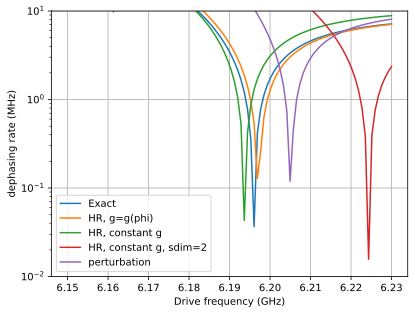

In [8]:
plt.plot(omega_ds, exact_energy01, label='Exact')
plt.plot(omega_ds, approx_energyg, label='HR, g=g(phi)')
plt.plot(omega_ds, approx_energynog, label='HR, constant g')
plt.plot(omega_ds, approx_energynogsdim2, label='HR, constant g, sdim=2')
plt.plot(omega_ds, approx_energyd, label='perturbation')
plt.yscale('log')
plt.xlabel('Drive frequency (GHz)')
plt.ylabel('dephasing rate (MHz)')
plt.ylim(1e-2, 1e1)
plt.legend()
plt.grid(True)
plt.show()

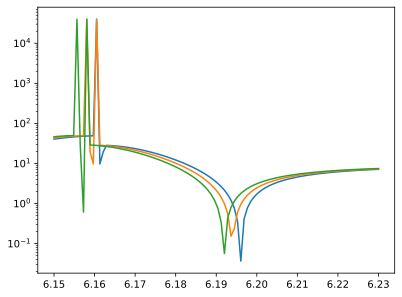

In [9]:
plt.plot(omega_ds, exact_energy01, label='Exact')
plt.plot(omega_ds, exact_energy02, label='Exact')
plt.plot(omega_ds, exact_energy03, label='Exact')
plt.yscale('log')

In [10]:
from joblib import Parallel, delayed

omega_ds_set = np.linspace(6.188, 6.189,100)
A = 10.e-3*2*np.pi

def calculate_energies(omega_d):
    exact_energy_inset = sc.calculate_dr_exact(A, omega_d*2*np.pi)[0]
    return exact_energy_inset

# Run calculations in parallel
results = Parallel(n_jobs=-1)(delayed(calculate_energies)(omega_d) for omega_d in omega_ds_set)

# Unzip results into separate lists
exact_energies_inset = list(results)  # No need to unzip since we only return one value


In [11]:
plt

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/site-packages/matplotlib/pyplot.py'>

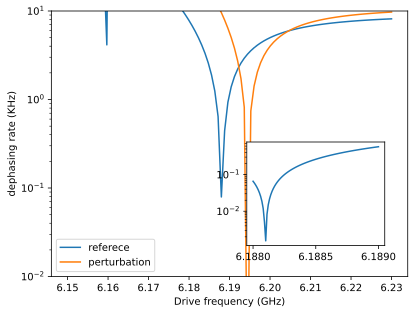

In [31]:
# Create the main plot
plt.plot(omega_ds, exact_energy01, label='referece')
plt.plot(omega_ds, approx_energyd, label='perturbation')
plt.yscale('log')
plt.xlabel('Drive frequency (GHz)')
plt.ylabel('dephasing rate (KHz)')
plt.ylim(1e-2, 1e1)
plt.legend()

# Create inset axes
axins = plt.axes([0.55, 0.2, 0.3, 0.3])  # [left, bottom, width, height] - moved to bottom right
axins.plot(omega_ds_set, exact_energies_inset)  # Convert GHz to MHz for x-axis
axins.set_yscale('log')

plt.show()

In [13]:
# Create 2D parameter sweep
omega_ds_2d = np.linspace(6.17, 6.19, 100)  # Drive frequencies in GHz
As_2d = 2*np.pi*np.linspace(1e-3, 10e-3, 100) # Drive amplitudes from 0.1 to 10 mA
omega_d_mesh, A_mesh = np.meshgrid(omega_ds_2d, As_2d)

# Define function for parallel computation
def calculate_dephasing(A, omega_d):
    der_exact = sc.calculate_dr_app(A, omega_d*2*np.pi, consider_g=True)
    der_app  = sc.derivative_approx(A, omega_d*2*np.pi)
    return der_exact, der_app

# Calculate dephasing rates in parallel
dephasing_rates = np.zeros_like(omega_d_mesh)
derivative_rates = np.zeros_like(omega_d_mesh)
results = Parallel(n_jobs=-1)(
    delayed(calculate_dephasing)(A_mesh.flatten()[i], omega_d_mesh.flatten()[i]) 
    for i in range(len(A_mesh.flatten()))
)
dephasing_rates = np.array([r[0] for r in results]).reshape(omega_d_mesh.shape)
derivative_rates = np.array([r[1] for r in results]).reshape(omega_d_mesh.shape)

# Create 2D color plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

# Plot dephasing rates
from matplotlib.colors import LogNorm
im1 = ax1.pcolormesh(omega_d_mesh, A_mesh/2/np.pi, dephasing_rates, 
                     shading='auto',
                     norm=LogNorm(vmin=1e-2, vmax=1e1))
fig.colorbar(im1, ax=ax1, label='Dephasing rate (KHz)')
ax1.set_xlabel('Drive frequency (GHz)')
ax1.set_ylabel('Drive amplitude (GHz)')
ax1.set_title('Dephasing Rate vs Drive Parameters')
ax1.grid(False)

# Plot derivative
im2 = ax2.pcolormesh(omega_d_mesh, A_mesh/2/np.pi, derivative_rates,
                     shading='auto',
                     norm=LogNorm())
fig.colorbar(im2, ax=ax2, label='Derivative of dephasing rate (KHz)')
ax2.set_xlabel('Drive frequency (GHz)')
ax2.set_ylabel('Drive amplitude (GHz)')
ax2.set_title('Derivative of Dephasing Rate vs Drive Parameters')
ax2.grid(False)

plt.tight_layout()
plt.show()


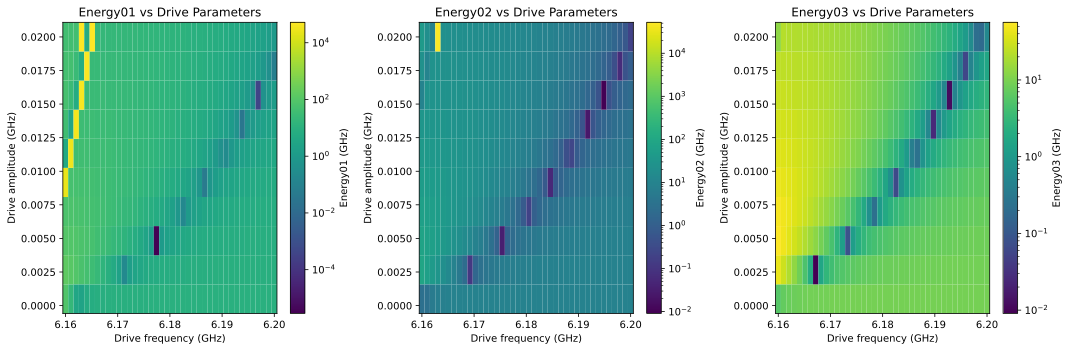

In [22]:
# Create 2D parameter sweep
omega_ds_2d = np.linspace(6.16, 6.2, 40)  # Drive frequencies in GHz
As_2d = 2*np.pi*np.linspace(5e-4, 20e-3, 10) # Drive amplitudes from 0.1 to 10 mA
omega_d_mesh, A_mesh = np.meshgrid(omega_ds_2d, As_2d)

# Define function for parallel computation
def calculate_dephasing(A, omega_d):
    energy01,energy02,energy03 = sc.calculate_dr_exact(A, omega_d*2*np.pi)
    return energy01,energy02,energy03

# Calculate energies in parallel
results = Parallel(n_jobs=-1)(
    delayed(calculate_dephasing)(A_mesh.flatten()[i], omega_d_mesh.flatten()[i]) 
    for i in range(len(A_mesh.flatten()))
)

# Reshape results into separate arrays for each energy
energy01_mesh = np.array([r[0] for r in results]).reshape(omega_d_mesh.shape)
energy02_mesh = np.array([r[1] for r in results]).reshape(omega_d_mesh.shape)
energy03_mesh = np.array([r[2] for r in results]).reshape(omega_d_mesh.shape)

# Create 2D color plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

# Plot energy01
from matplotlib.colors import LogNorm
im1 = ax1.pcolormesh(omega_d_mesh, A_mesh/2/np.pi, energy01_mesh, 
                     shading='auto', norm=LogNorm())
fig.colorbar(im1, ax=ax1, label='Energy01 (GHz)')
ax1.set_xlabel('Drive frequency (GHz)')
ax1.set_ylabel('Drive amplitude (GHz)')
ax1.set_title('Energy01 vs Drive Parameters')
ax1.grid(False)

# Plot energy02
im2 = ax2.pcolormesh(omega_d_mesh, A_mesh/2/np.pi, energy02_mesh, 
                     shading='auto', norm=LogNorm())
fig.colorbar(im2, ax=ax2, label='Energy02 (GHz)')
ax2.set_xlabel('Drive frequency (GHz)')
ax2.set_ylabel('Drive amplitude (GHz)')
ax2.set_title('Energy02 vs Drive Parameters')
ax2.grid(False)

# Plot energy03
im3 = ax3.pcolormesh(omega_d_mesh, A_mesh/2/np.pi, energy03_mesh, 
                     shading='auto', norm=LogNorm())
fig.colorbar(im3, ax=ax3, label='Energy03 (GHz)')
ax3.set_xlabel('Drive frequency (GHz)')
ax3.set_ylabel('Drive amplitude (GHz)')
ax3.set_title('Energy03 vs Drive Parameters')
ax3.grid(False)

plt.tight_layout()
plt.show()
